 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..

In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [5]:
observation = 'newly_infected' #'newly_infected' #'hospitalization'
rolling_avg_obs = 7
# Overall Time Period
start_time='2020-06-15' 
end_time='2021-06-15' # Begin Delta Wave

# Training Time Period
start_time_train=start_time
end_time_train='2021-01-31'

#Test Time Period
start_time_test='2021-02-01'
end_time_test=end_time

dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/220309_observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs_train, initial_newly_infected_train = initialize_observations(df_obs_initial, start=start_time_train, end=end_time_train, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs_train[observation], requires_grad=False, device=device, dtype=dtype)

# Initialize Observations Testing
df_obs_test, initial_newly_infected_test = initialize_observations(df_obs_initial, start=start_time_test, end=end_time_test, rolling_avg=rolling_avg_obs)
observed_test = torch.tensor(df_obs_test[observation], requires_grad=False, device=device, dtype=dtype)

# Create df_obs
df_obs = pd.concat([df_obs_train, df_obs_test])

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-06-15,0.714286,37.142857,2.285714
1,2020-06-16,0.857143,39.571429,3.142857
2,2020-06-17,1.000000,44.714286,3.714286


In [7]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

## Initialize Model Parameter

### Initialize helper parameter

In [8]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
#num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [9]:
method = TwoClusterNN(device=device, dtype=dtype)

### Initialize alpha and phi

In [10]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(-0.0746, requires_grad=True),
  'phi': tensor(-0., requires_grad=True)},
 'real_values': {'alpha': tensor(0.0100, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

## Load Method Input Data

In [11]:
def get_input_data(start, end):
  df_cluster = pd.read_csv('data/clustering/220309_percentage_careful.csv' , parse_dates=['date'])
  df_cluster['percentage'] = df_cluster['percentage'].rolling(7).mean()
  # Standardize Input Data
  time_period = (df_cluster['date'] >= start) & (df_cluster['date'] < end)
  input_data = df_cluster.loc[time_period]['percentage'].copy()
  return input_data.to_numpy()

In [12]:
cluster_percentage_train = get_input_data(start_time_train, end_time_train)
cluster_percentage_test = get_input_data(start_time_test, end_time_test)

# Optimization

## Training

Step: 0, Time: 0.3510622978210449, Loss: 36632592.0, Mean Expected Daily Hospit: 1.0667972564697266


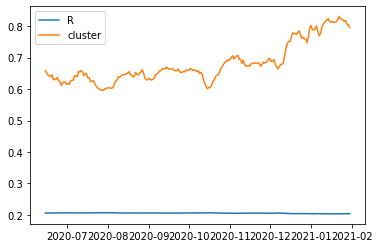

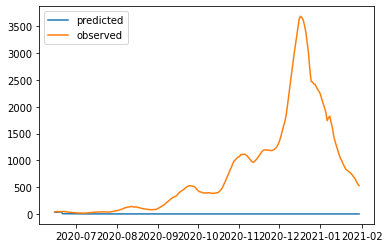

Step: 50, Time: 0.2158031463623047, Loss: 36632028.0, Mean Expected Daily Hospit: 1.485554814338684


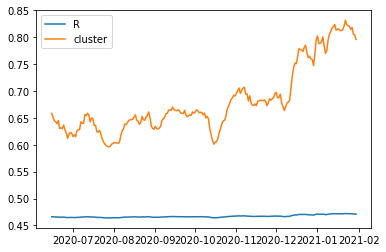

Step: 100, Time: 0.1386570930480957, Loss: 24112354.0, Mean Expected Daily Hospit: 223.59689331054688


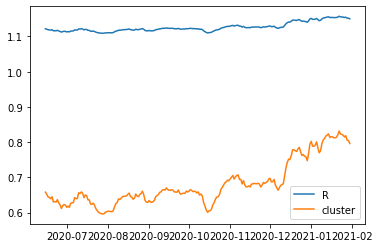

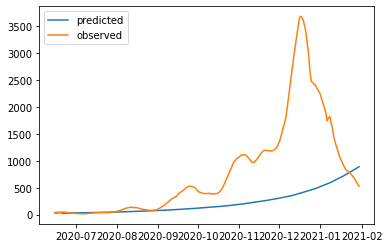

Step: 150, Time: 0.11061263084411621, Loss: 16494119.0, Mean Expected Daily Hospit: 526.6255493164062


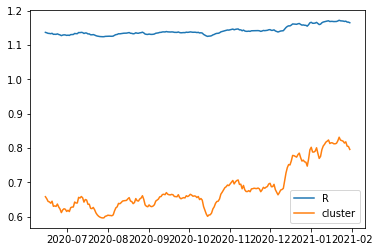

Step: 200, Time: 0.12071990966796875, Loss: 16419897.0, Mean Expected Daily Hospit: 540.2228393554688


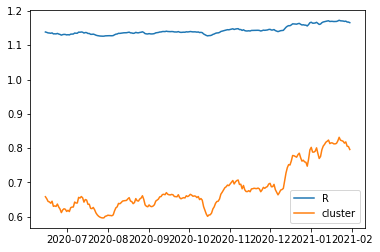

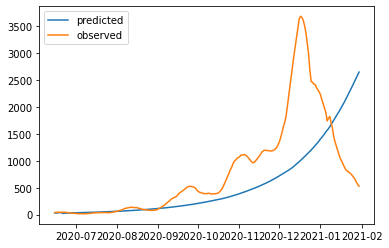

Step: 250, Time: 0.11792469024658203, Loss: 16346888.0, Mean Expected Daily Hospit: 540.9669799804688


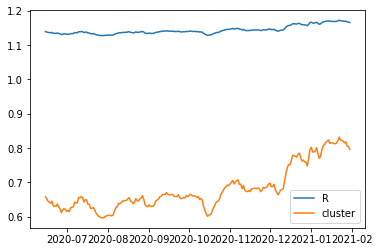

Step: 300, Time: 0.12004327774047852, Loss: 16266186.0, Mean Expected Daily Hospit: 542.9650268554688


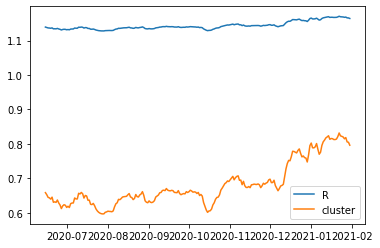

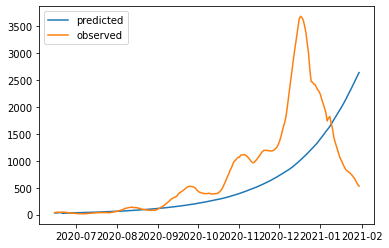

Step: 350, Time: 0.11561036109924316, Loss: 16177972.0, Mean Expected Daily Hospit: 545.1104125976562


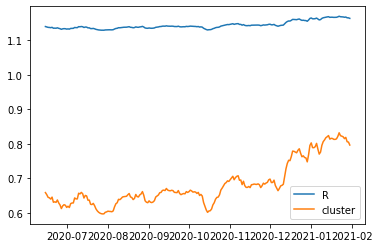

Step: 400, Time: 0.12957549095153809, Loss: 16082095.0, Mean Expected Daily Hospit: 547.4374389648438


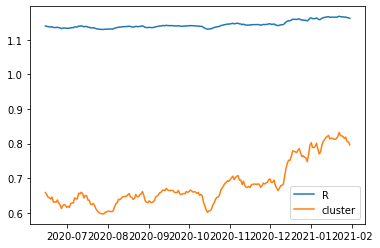

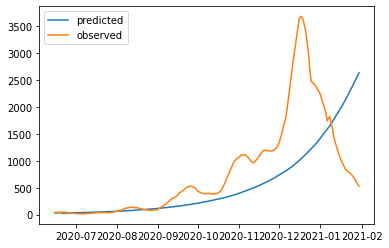

Step: 450, Time: 0.15590691566467285, Loss: 15977942.0, Mean Expected Daily Hospit: 549.9632568359375


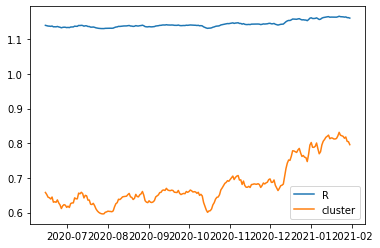

Step: 500, Time: 0.13835382461547852, Loss: 15864386.0, Mean Expected Daily Hospit: 552.7158813476562


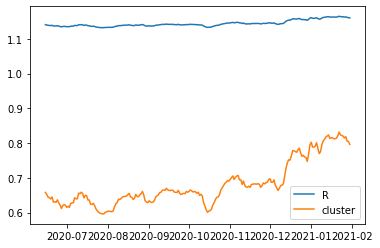

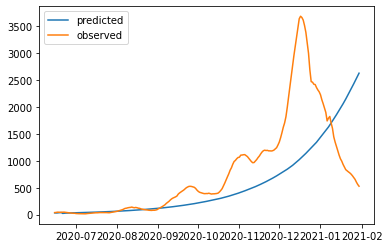

Step: 550, Time: 0.11237406730651855, Loss: 15739650.0, Mean Expected Daily Hospit: 555.7384033203125


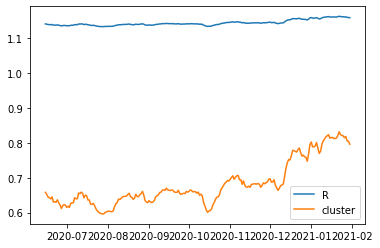

Step: 600, Time: 0.12627792358398438, Loss: 15601130.0, Mean Expected Daily Hospit: 559.0881958007812


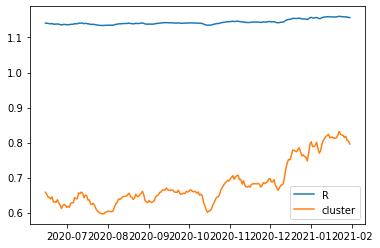

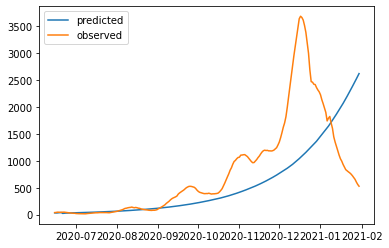

Step: 650, Time: 0.35927534103393555, Loss: 15445083.0, Mean Expected Daily Hospit: 562.8650512695312


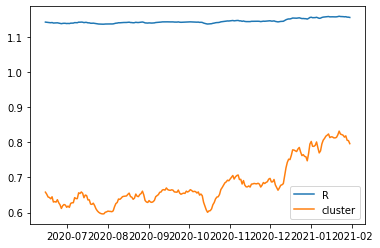

Step: 700, Time: 0.12736105918884277, Loss: 15266198.0, Mean Expected Daily Hospit: 567.1898803710938


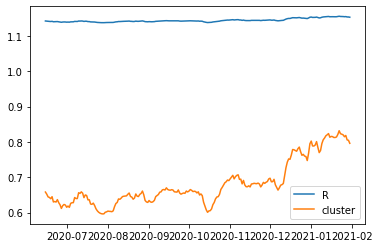

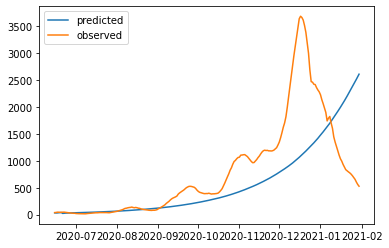

Step: 750, Time: 0.1271052360534668, Loss: 15056878.0, Mean Expected Daily Hospit: 572.2507934570312


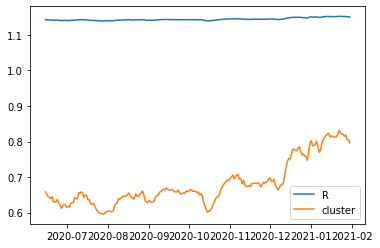

Step: 800, Time: 0.130706787109375, Loss: 14806219.0, Mean Expected Daily Hospit: 578.3115234375


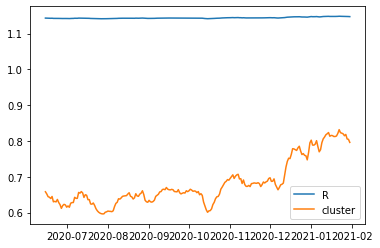

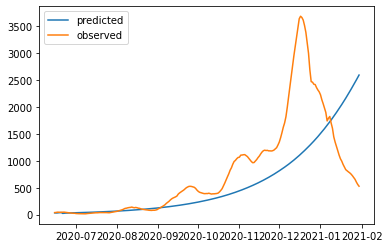

Step: 850, Time: 0.13425326347351074, Loss: 14498280.0, Mean Expected Daily Hospit: 585.7661743164062


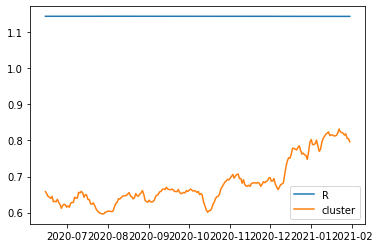

Step: 900, Time: 0.12819504737854004, Loss: 14109473.0, Mean Expected Daily Hospit: 595.191650390625


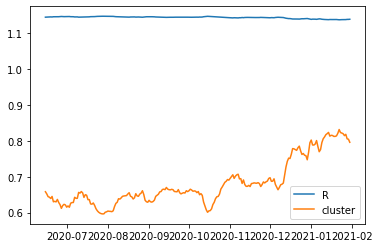

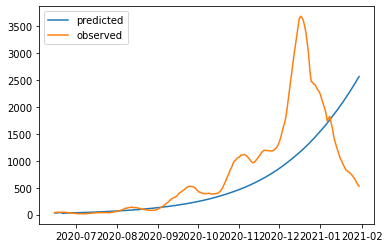

Step: 950, Time: 0.12170934677124023, Loss: 13604386.0, Mean Expected Daily Hospit: 607.4653930664062


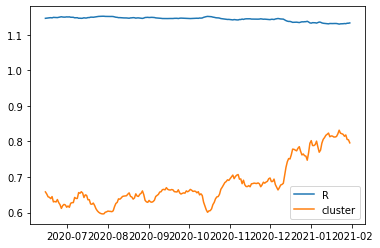

Step: 1000, Time: 0.11075806617736816, Loss: 12929672.0, Mean Expected Daily Hospit: 623.9376831054688


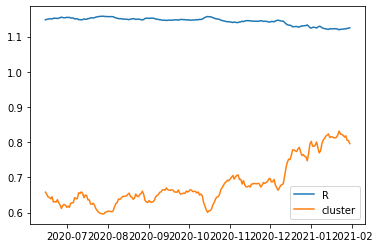

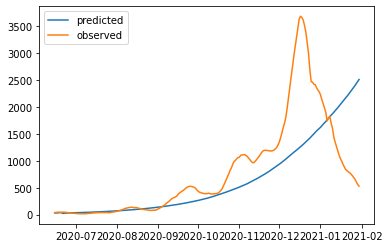

Step: 1050, Time: 0.10819196701049805, Loss: 12006909.0, Mean Expected Daily Hospit: 646.6130981445312


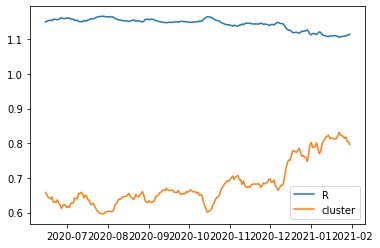

Step: 1100, Time: 0.11944913864135742, Loss: 10733138.0, Mean Expected Daily Hospit: 678.2902221679688


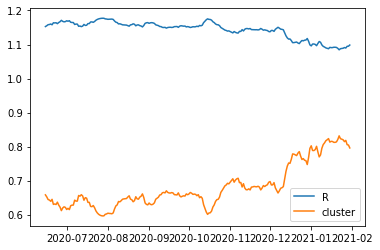

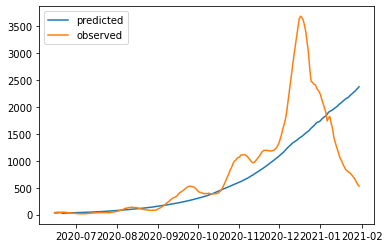

Step: 1150, Time: 0.10902690887451172, Loss: 9025526.0, Mean Expected Daily Hospit: 721.7122802734375


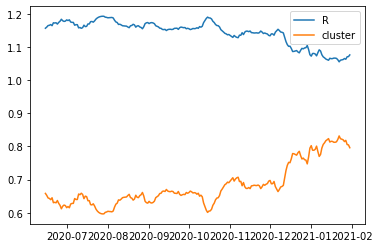

Step: 1200, Time: 0.1117551326751709, Loss: 6999602.5, Mean Expected Daily Hospit: 775.5737915039062


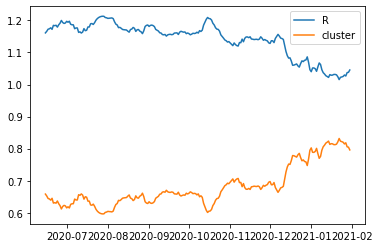

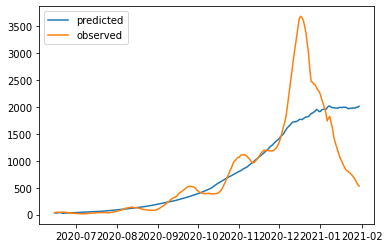

Step: 1250, Time: 0.13035821914672852, Loss: 5337315.5, Mean Expected Daily Hospit: 808.2196044921875


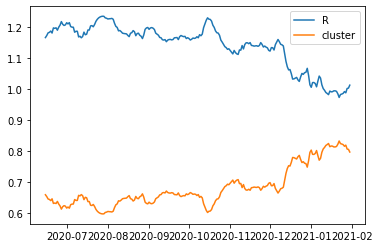

Step: 1300, Time: 0.13803815841674805, Loss: 4484433.5, Mean Expected Daily Hospit: 851.83251953125


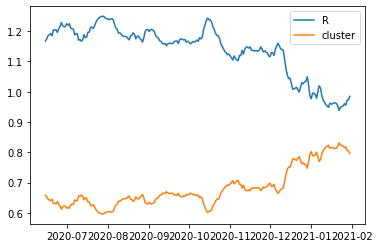

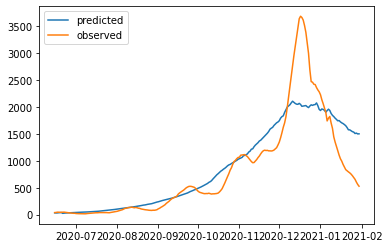

Step: 1350, Time: 0.12845754623413086, Loss: 4147893.25, Mean Expected Daily Hospit: 868.2972412109375


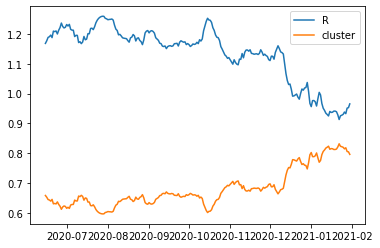

Step: 1400, Time: 0.11175322532653809, Loss: 4056563.5, Mean Expected Daily Hospit: 871.8944091796875


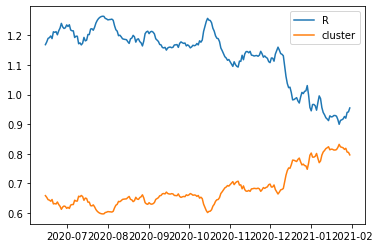

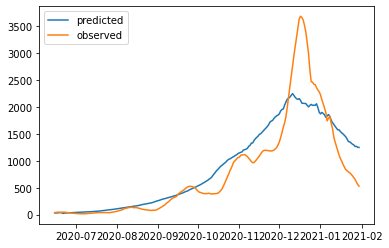

Step: 1450, Time: 0.12761974334716797, Loss: 4034362.0, Mean Expected Daily Hospit: 878.515625


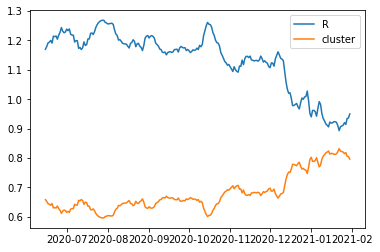

Step: 1500, Time: 0.12146377563476562, Loss: 4029490.0, Mean Expected Daily Hospit: 879.4267578125


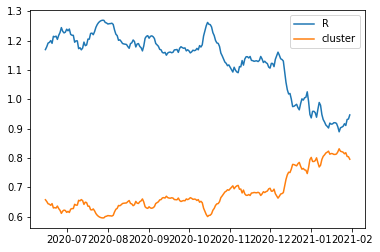

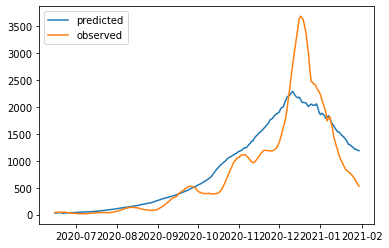

Step: 1550, Time: 0.12392735481262207, Loss: 4031246.75, Mean Expected Daily Hospit: 872.4891967773438


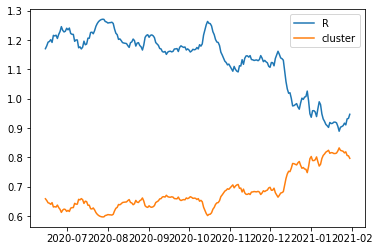

Step: 1600, Time: 0.12734031677246094, Loss: 4028535.75, Mean Expected Daily Hospit: 882.176513671875


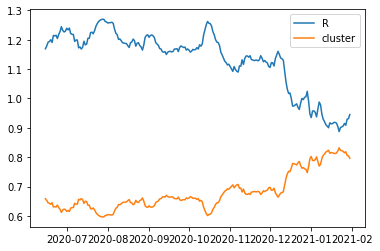

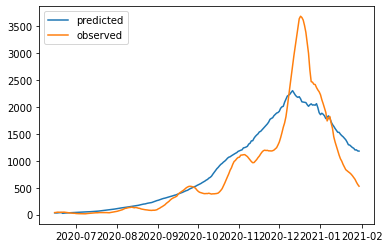

Step: 1650, Time: 0.12107372283935547, Loss: 4028294.5, Mean Expected Daily Hospit: 880.3168334960938


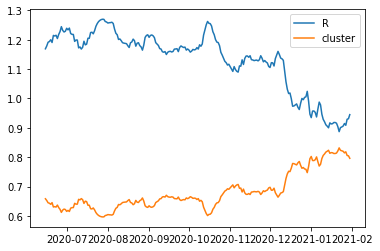

Step: 1700, Time: 0.12011218070983887, Loss: 4028287.5, Mean Expected Daily Hospit: 880.325927734375


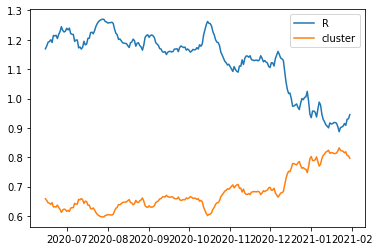

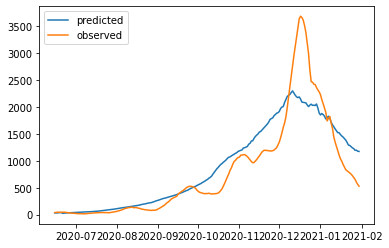

Step: 1750, Time: 0.11314249038696289, Loss: 4028304.5, Mean Expected Daily Hospit: 880.9196166992188


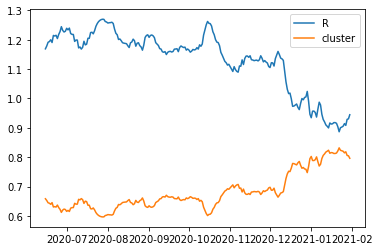

Step: 1800, Time: 0.12467122077941895, Loss: 4028323.75, Mean Expected Daily Hospit: 879.4442138671875


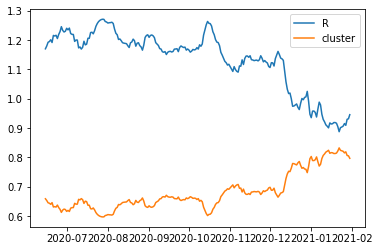

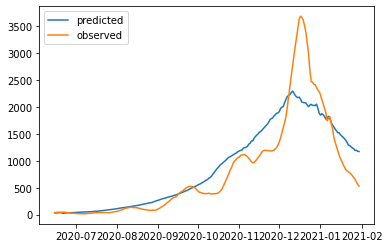

Step: 1850, Time: 0.12727975845336914, Loss: 4028286.5, Mean Expected Daily Hospit: 880.3867797851562


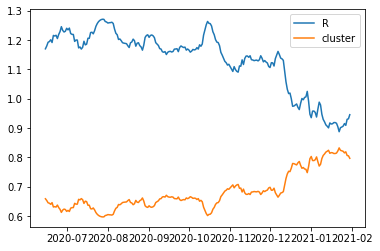

Step: 1900, Time: 0.12583160400390625, Loss: 4028285.75, Mean Expected Daily Hospit: 880.2050170898438


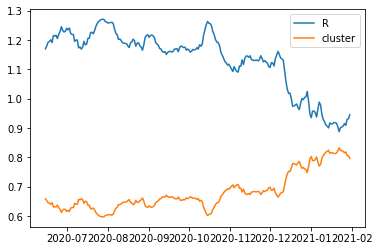

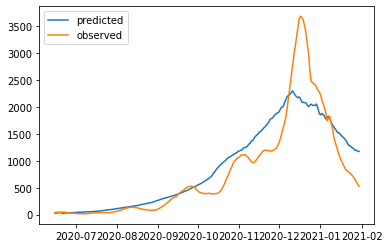

Step: 1950, Time: 0.10678863525390625, Loss: 4028448.25, Mean Expected Daily Hospit: 878.5010375976562


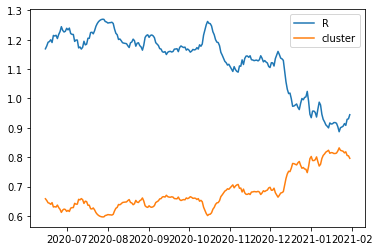

In [13]:
epochs = 2000
model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']]

params_to_be_optimized = method.get_parameters() #+ [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.001, weight_decay=0)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(population, R=method.calculate_R(cluster_percentage_train), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
  
  # calc loss
  comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi']
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss_train + method_loss + model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 50==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')
      plt.plot(df_obs_train['Date'], method.calculate_R(cluster_percentage_train).cpu().detach().numpy(), label='R')
      plt.plot(df_obs_train['Date'], cluster_percentage_train, label='cluster')
      plt.legend()
      plt.show()
  if i % 100==0:
    #print(method.calculate_R(cluster_percentage))
    plt.plot(df_obs_train['Date'], expected.cpu().detach().numpy(), label='predicted')
    plt.plot(df_obs_train['Date'], observed_train.cpu().detach().numpy(), label='observed')
    plt.legend()
    plt.show()


# Evaluation

## Train and Test Time 

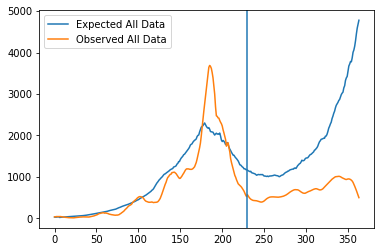

In [14]:
cluster_percentage_train_test = np.concatenate((cluster_percentage_train, cluster_percentage_test), axis=None)
expected_train_test = epid_model(population, R=method.calculate_R(cluster_percentage_train_test), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
observed_train_test = torch.concat((observed_train, observed_test))

plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

## Eval on Test Data

Comparison Loss Train: 4028297.75 - Comparison Loss Test: 41331148.0


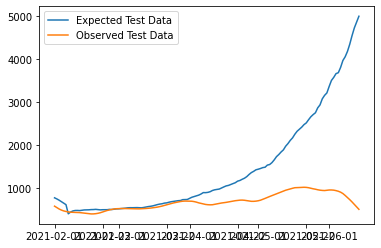

In [15]:
expected_test = epid_model(population, R=method.calculate_R(cluster_percentage_test), initial_newly_infected = initial_newly_infected_test, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
comparison_loss_test = calc_mse(expected_test, observed_test) * dict_param['real_values']['phi']
print(f'Comparison Loss Train: {comparison_loss_train} - Comparison Loss Test: {comparison_loss_test}')

plt.plot(df_obs_test['Date'], expected_test.cpu().detach().numpy(),label='Expected Test Data')
plt.plot(df_obs_test['Date'], observed_test.cpu().detach().numpy(),label='Observed Test Data')
plt.legend()
plt.show()

## Eval What IF

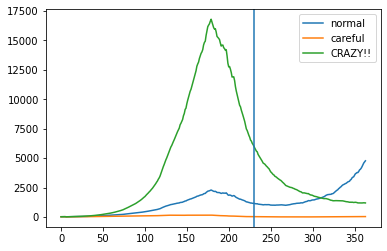

In [16]:
expected_normal = epid_model(population, R=method.calculate_R(cluster_percentage_train_test), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_careful= epid_model(population, R=method.calculate_R(cluster_percentage_train_test*1.1), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_crazy = epid_model(population, R=method.calculate_R(cluster_percentage_train_test*0.9), initial_newly_infected = initial_newly_infected_train, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

plt.plot(expected_normal.cpu().detach().numpy(),label='normal')
plt.plot(expected_careful.cpu().detach().numpy(),label='careful')
plt.plot(expected_crazy.cpu().detach().numpy(),label='CRAZY!!')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

## Eval Cluster Percentage vs R-Value

Slope: -1.6294327699221076, intercept: 2.2419934982281235, r-squared: 0.9999999999997691


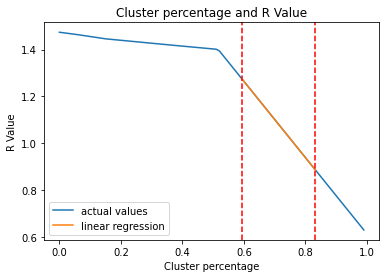

In [17]:
from scipy import stats

x = np.arange(0,1 , 0.01)
y = np.squeeze(method.calculate_R(x).cpu().detach().numpy())


x_min = cluster_percentage_train_test.min()
x_max = cluster_percentage_train_test.max()
x_bound = np.arange(x_min, x_max + 0.01 , 0.01)
y_bound = np.squeeze(method.calculate_R(x_bound).cpu().detach().numpy())

slope, intercept, r_value, p_value, std_err = stats.linregress(x_bound, y_bound)
y_linreg = intercept + slope * x_bound
print(f'Slope: {slope}, intercept: {intercept}, r-squared: {r_value**2}')
plt.plot(x, y, label='actual values')
plt.plot(x_bound, y_linreg, label='linear regression')
plt.axvline(x=x_min, c='r', linestyle='--')
plt.axvline(x=x_max, c='r', linestyle='--')
plt.xlabel('Cluster percentage')
plt.ylabel('R Value')
plt.title('Cluster percentage and R Value')
plt.legend()
plt.show()